#**1. Dependencies & imports**

In [ ]:
!pip install -q kaggle
!pip install tensorflow
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Add, BatchNormalization, Conv2D, Dense, Dropout, GlobalAveragePooling2D,
    Input, Multiply, ReLU, Reshape
)
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

from functools import partial

#**2. Parameter Configuration**

In [ ]:
IMG_SIZE = 96
BATCH_SIZE = 32
SEED = 42
EPOCHS_KFOLD = 50

CLASS_NAMES = {
    0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy",
    4: "Sad", 5: "Surprise", 6: "Neutral"
}
TRAIN_DIR = "fer2013/train"
TEST_DIR = "fer2013/test"
OUTPUT_DIR = "models_output"
os.makedirs(OUTPUT_DIR , exist_ok=True)

#**3. Dataset**

##3.1 Download Dataset

In [ ]:
# Add your Kaggle credentials here
kaggle_token = {
    "username": "your_username",
    "key": "your_key"
}

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_token, f)

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d msambare/fer2013
!unzip -q fer2013.zip -d fer2013


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.39GB/s]


##3.2 Data Loading and Preprocessing

In [ ]:
def get_file_paths_and_labels(data_dir):
    # Collects all image file paths and assigns numeric labels based on class folder names
    class_names = sorted(os.listdir(data_dir))
    file_paths = []
    labels = []
    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for fname in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, fname))
            labels.append(idx)
    return np.array(file_paths), np.array(labels), class_names


def load_and_preprocess(path, label):
    # Loads an image from disk, resizes it, normalizes pixel values, and one-hot encodes the label
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.image.grayscale_to_rgb(image)  # Needed if model expects 3-channel input
    image = image / 255.0
    label = tf.one_hot(label, depth=len(CLASS_NAMES))
    return image, label


def create_dataset(file_paths, labels, batch_size=BATCH_SIZE, shuffle=True):
    # Builds a TensorFlow dataset pipeline with optional shuffling, preprocessing, batching, and prefetching
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(file_paths), seed=SEED)
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

#**4. Visualizations**

##4.1 EDA

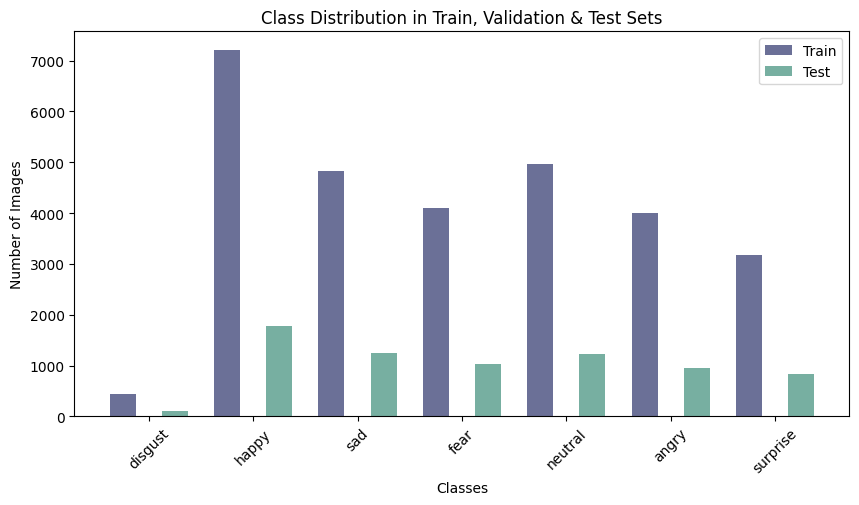

In [ ]:
# Function to count number of images in each class folder within a directory
def count_images_per_class(directory):
    class_counts = {}
    for cls in os.listdir(directory):
        class_name = cls
        class_counts[class_name] = len(os.listdir(os.path.join(directory, cls)))
    return class_counts

# Count images per class for training and testing datasets
train_counts = count_images_per_class(TRAIN_DIR)
test_counts = count_images_per_class(TEST_DIR)

# Prepare data for bar chart plotting
labels = list(train_counts.keys())
train_values = [train_counts[cls] for cls in labels]
test_values = [test_counts[cls] for cls in labels]

x = np.arange(len(labels))  # X-axis positions for class labels
width = 0.25  # Width of each bar

# Plot grouped bar chart comparing train and test distributions
plt.figure(figsize=(10, 5))
plt.bar(x - width, train_values, width=width, label="Train", color="#2D336B", alpha=0.7)
plt.bar(x + width, test_values, width=width, label="Test", color="#3D8D7A", alpha=0.7)

plt.xticks(x, labels, rotation=45)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Train, Validation & Test Sets")
plt.legend()
plt.show()

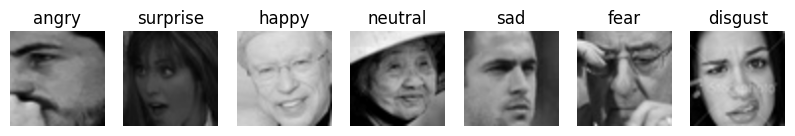

In [ ]:
# Function to extract strictly one sample per class
def get_one_sample_per_class(dataset, class_names):
    class_samples = {}

    for images, labels in dataset:
        for img, label in zip(images.numpy(), labels.numpy()):
            label_index = np.argmax(label)
            class_name = class_names[label_index]
            if class_name not in class_samples:
                class_samples[class_name] = img
            if len(class_samples) == len(class_names):
                break
        if len(class_samples) == len(class_names):
            break

    return class_samples

# Get one sample per class
file_paths_train, labels_train, class_names = get_file_paths_and_labels(TRAIN_DIR)
train_ds = create_dataset(file_paths_train, labels_train)

class_samples = get_one_sample_per_class(train_ds, class_names)


# Plot one image per class
plt.figure(figsize=(10, 10))
for i, (class_name, img) in enumerate(class_samples.items()):
    plt.subplot(1,7,i+1)
    plt.imshow((img * 255).astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.show()

##4.2 Plot Training Curves

In [ ]:
# Plots training and validation accuracy/loss curves and saves the figure
def plot_training_curves(history, model_name="Model", output_dir=OUTPUT_DIR):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))  # X-axis range based on number of epochs

    plt.figure(figsize=(12, 5))

    # Plot accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title(f"{model_name} - Accuracy")

    # Plot loss curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title(f"{model_name} - Loss")

    plt.tight_layout()

    # Save plot image with model name in file name
    plot_path = os.path.join(output_dir, f"{model_name.replace(' ', '_')}_training_plot.png")
    plt.savefig(plot_path)
    plt.close()

#**5. Transfer Learning**

##5.1 Inception V3

###*5.1.1 K-Fold Training*

In [ ]:
# Performs k-fold cross-validation using InceptionV3 and tf.data input pipeline
def train_and_evaluate_kfold_inception_tfdata(data_dir_train, data_dir_test, k=5):
    # Load file paths and labels for train and test
    train_files, train_labels, class_names = get_file_paths_and_labels(data_dir_train)
    test_files, test_labels, _ = get_file_paths_and_labels(data_dir_test)

    # Prepare test dataset without shuffling
    test_ds = create_dataset(test_files, test_labels, shuffle=False)

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)
    acc_scores = []
    all_metrics = []

    model_output_dir = os.path.join(OUTPUT_DIR, "inception")
    os.makedirs(model_output_dir, exist_ok=True)

    # Custom data augmentation layer using Keras Sequential API
    class AugmentationLayer(tf.keras.layers.Layer):
        def __init__(self):
            super().__init__()
            self.augment = tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal"),
                tf.keras.layers.RandomRotation(0.1),
                tf.keras.layers.RandomZoom(0.1),
                tf.keras.layers.RandomContrast(0.1)
            ])

        def build(self, input_shape):
            super().build(input_shape)

        def call(self, inputs, training=None):
            return self.augment(inputs) if training else inputs

    # K-Fold training loop
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_files, train_labels), 1):
        print(f"\nFold {fold}/{k}")

        fold_train_ds = create_dataset(train_files[train_idx], train_labels[train_idx], shuffle=True)
        fold_val_ds = create_dataset(train_files[val_idx], train_labels[val_idx], shuffle=False)

        # Build model with augmentation and InceptionV3 base
        inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = AugmentationLayer()(inputs)

        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
        base_model.trainable = True

        x = base_model(x, training=True)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

        model = tf.keras.Model(inputs, outputs)

        model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
            #optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train model on current fold
        history = model.fit(
            fold_train_ds,
            validation_data=fold_val_ds,
            epochs=EPOCHS_KFOLD,
            callbacks=[early_stop],
            verbose=1
        )

        # Evaluate on test dataset
        test_pred_probs = model.predict(test_ds)
        test_pred_labels = tf.argmax(test_pred_probs, axis=1).numpy()
        test_true_labels = test_labels

        acc = accuracy_score(test_true_labels, test_pred_labels)
        f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
        acc_scores.append(acc)

        print(f" Fold {fold} Test Accuracy: {acc:.4f}")
        print(f" Fold {fold} Test Weighted F1 Score: {f1:.4f}")

        # Save training curves for current fold
        plot_training_curves(history, model_name=f"Inception Fold {fold}", output_dir=model_output_dir)

        #model_save_path = os.path.join(model_output_dir, f"inception_model_fold_{fold}.keras")
        #model.save(model_save_path)

        # Collect fold metrics for later analysis
        fold_metrics = {
            'Fold': fold,
            'Accuracy': acc,
            'F1 Score': f1,
            'Epochs Run': len(history.history['loss']),
            'Train Size': len(train_idx),
            'Val Size': len(val_idx),
            'Test Size': len(test_true_labels),
            'IMG_SIZE': IMG_SIZE,
            'BATCH_SIZE': BATCH_SIZE,
            'SEED': SEED,
            'Model': 'InceptionV3',
            'Data Augmentation': True
        }
        all_metrics.append(fold_metrics)

        # Clean up to free memory before next fold
        del model
        del history
        K.clear_session()
        gc.collect()

    # Save aggregated fold metrics to Excel
    metrics_df = pd.DataFrame(all_metrics)
    metrics_save_path = os.path.join(model_output_dir, "inception_fold_metrics.xlsx")
    metrics_df.to_excel(metrics_save_path, index=False)

    print(f"\n Inception Avg Accuracy: {np.mean(acc_scores):.4f}")
    print(f" Inception Max Accuracy: {np.max(acc_scores):.4f}")

    return acc_scores

###*5.1.2 Run Pipeline*

In [ ]:
# Run K-Fold cross-validation using InceptionV3 model on train/test directories
inception_scores = train_and_evaluate_kfold_inception_tfdata(TRAIN_DIR, TEST_DIR, k=5)

# Copy model outputs (e.g., plots, metrics) to Google Drive for persistence
!cp -r models_output/inception /content/drive/MyDrive/inception_output


Fold 1/5
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 120s 114ms/step - accuracy: 0.2628 - loss: 1.8122 - val_accuracy: 0.4626 - val_loss: 1.4182
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 133s 109ms/step - accuracy: 0.4546 - loss: 1.4234 - val_accuracy: 0.5113 - val_loss: 1.3314
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 79s 105ms/step - accuracy: 0.5094 - loss: 1.2979 - val_accuracy: 0.5381 - val_loss: 1.2152
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 81s 104ms/step - accuracy: 0.5403 - loss: 1.1953 - val_accuracy: 0.5644 - val_loss: 1.1555
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 84s 107ms/step - accuracy: 0.5724 - loss: 1.1422 - val_accuracy: 0.5761 - val_loss: 1.1343
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 79s 103ms/step - accuracy: 0.5904 - loss: 1.0899 - val_accuracy: 0.5958 - val_loss: 1.0940
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 85s 107ms/step - accuracy: 0.6001 - loss: 1.0563 - val_accuracy: 0.5940 - val_loss: 1.0920
Epoch 8/50
718/718 ━

##5.2 VGG16

###*5.2.1 K-Fold Training*

In [ ]:
# Performs k-fold cross-validation using VGG16 and tf.data input pipeline
def train_and_evaluate_kfold_vgg_tfdata(data_dir_train, data_dir_test, k=5):
    # Load file paths and labels for train and test
    train_files, train_labels, class_names = get_file_paths_and_labels(data_dir_train)
    test_files, test_labels, _ = get_file_paths_and_labels(data_dir_test)

    # Prepare test dataset without shuffling
    test_ds = create_dataset(test_files, test_labels, shuffle=False)

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)
    acc_scores = []
    all_metrics = []

    model_output_dir = os.path.join(OUTPUT_DIR, "vgg")
    os.makedirs(model_output_dir, exist_ok=True)

    # Custom data augmentation layer using Keras Sequential API
    class AugmentationLayer(tf.keras.layers.Layer):
        def __init__(self):
            super().__init__()
            self.augment = tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal"),
                tf.keras.layers.RandomRotation(0.1),
                tf.keras.layers.RandomZoom(0.1),
                tf.keras.layers.RandomContrast(0.1)
            ])

        def build(self, input_shape):
            super().build(input_shape)

        def call(self, inputs, training=None):
            return self.augment(inputs) if training else inputs

    # K-Fold training loop
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_files, train_labels), 1):
        print(f"\nFold {fold}/{k}")

        fold_train_ds = create_dataset(train_files[train_idx], train_labels[train_idx], shuffle=True)
        fold_val_ds = create_dataset(train_files[val_idx], train_labels[val_idx], shuffle=False)

        # Build model with augmentation and VGG16 base
        inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = AugmentationLayer()(inputs)

        vgg_base = tf.keras.applications.VGG16(
            weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
        vgg_base.trainable = True
        x = vgg_base(x, training=True)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.4)(x)
        outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

        model = tf.keras.Model(inputs, outputs)

        model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        )

        # Train model on current fold
        history = model.fit(
            fold_train_ds,
            epochs=EPOCHS_KFOLD,
            validation_data=fold_val_ds,
            callbacks=[early_stop],
            verbose=1
        )

        # Evaluate on test dataset
        test_pred_probs = model.predict(test_ds)
        test_pred_labels = tf.argmax(test_pred_probs, axis=1).numpy()
        acc = accuracy_score(test_labels, test_pred_labels)
        f1 = f1_score(test_labels, test_pred_labels, average='weighted')
        acc_scores.append(acc)

        print(f" Fold {fold} Test Accuracy: {acc:.4f}")
        print(f" Fold {fold} Test Weighted F1 Score: {f1:.4f}")

        # Save training curves for current fold
        plot_training_curves(history, model_name=f"VGG Fold {fold}", output_dir=model_output_dir)

        #model_save_path = os.path.join(model_output_dir, f"vgg_model_fold_{fold}.keras")
        #model.save(model_save_path)

        # Collect fold metrics for later analysis
        fold_metrics = {
            'Fold': fold,
            'Accuracy': acc,
            'F1 Score': f1,
            'Epochs Run': len(history.history['loss']),
            'Train Size': len(train_idx),
            'Val Size': len(val_idx),
            'Test Size': len(test_labels),
            'IMG_SIZE': IMG_SIZE,
            'BATCH_SIZE': BATCH_SIZE,
            'SEED': SEED,
            'Model': 'VGG16',
            'Data Augmentation': True
        }
        all_metrics.append(fold_metrics)

        # Clean up to free memory before next fold
        del model
        del history
        K.clear_session()
        gc.collect()

    # Save aggregated fold metrics to Excel
    metrics_df = pd.DataFrame(all_metrics)
    metrics_save_path = os.path.join(model_output_dir, "vgg_fold_metrics.xlsx")
    metrics_df.to_excel(metrics_save_path, index=False)

    print(f"\n VGG Avg Accuracy: {np.mean(acc_scores):.4f}")
    print(f" VGG Max Accuracy: {np.max(acc_scores):.4f}")

    return acc_scores

###*5.2.2 Run Pipeline*

In [ ]:
# Run K-Fold training for VGG16
vgg_scores = train_and_evaluate_kfold_vgg_tfdata(TRAIN_DIR, TEST_DIR, k=5)

# Save model outputs to Google Drive
!cp -r models_output/vgg /content/drive/MyDrive/vgg16_output


Fold 1/5
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 94s 113ms/step - accuracy: 0.3158 - loss: 1.6983 - val_accuracy: 0.5155 - val_loss: 1.2587
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 128s 103ms/step - accuracy: 0.5067 - loss: 1.3005 - val_accuracy: 0.5488 - val_loss: 1.1694
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.5499 - loss: 1.1806 - val_accuracy: 0.5846 - val_loss: 1.0987
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.5798 - loss: 1.1079 - val_accuracy: 0.6008 - val_loss: 1.0420
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 81s 102ms/step - accuracy: 0.5990 - loss: 1.0675 - val_accuracy: 0.6059 - val_loss: 1.0346
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.6183 - loss: 1.0167 - val_accuracy: 0.6165 - val_loss: 1.0074
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.6273 - loss: 1.0002 - val_accuracy: 0.6153 - val_loss: 1.0056
Epoch 8/50
718/718 ━━

##5.3 MobileNetV2

###*5.3.1 K-Fold Training*

In [ ]:
def train_and_evaluate_kfold_mobilenet_tfdata(data_dir_train, data_dir_test, k=5):
    # Load file paths + labels for train and test datasets
    train_files, train_labels, class_names = get_file_paths_and_labels(data_dir_train)
    test_files, test_labels, _ = get_file_paths_and_labels(data_dir_test)

    # Prepare test dataset (no shuffle, no augmentation)
    test_ds = create_dataset(test_files, test_labels, shuffle=False)

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)
    acc_scores = []
    all_metrics = []

    model_output_dir = os.path.join(OUTPUT_DIR, "mobilenetv2")
    os.makedirs(model_output_dir, exist_ok=True)

    # Data augmentation layer applied during training only
    class AugmentationLayer(tf.keras.layers.Layer):
        def __init__(self):
            super().__init__()
            self.augment = tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal"),
                tf.keras.layers.RandomRotation(0.1),
                tf.keras.layers.RandomZoom(0.1),
                tf.keras.layers.RandomContrast(0.1)
            ])

        def build(self, input_shape):
            super().build(input_shape)

        def call(self, inputs, training=None):
            return self.augment(inputs) if training else inputs

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_files, train_labels), 1):
        print(f"\nFold {fold}/{k}")

        fold_train_ds = create_dataset(train_files[train_idx], train_labels[train_idx], shuffle=True)
        fold_val_ds = create_dataset(train_files[val_idx], train_labels[val_idx], shuffle=False)

        inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = AugmentationLayer()(inputs)

        base_model = tf.keras.applications.MobileNetV2(
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            include_top=False,
            weights='imagenet'
        )
        base_model.trainable = True  # fine-tuning enabled

        x = base_model(x, training=True)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

        model = tf.keras.Model(inputs, outputs)

        model.compile(
            #optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        )

        history = model.fit(
            fold_train_ds,
            epochs=EPOCHS_KFOLD,
            validation_data=fold_val_ds,
            callbacks=[early_stop],
            verbose=1
        )

        test_pred_probs = model.predict(test_ds)
        test_pred_labels = tf.argmax(test_pred_probs, axis=1).numpy()
        acc = accuracy_score(test_labels, test_pred_labels)
        f1 = f1_score(test_labels, test_pred_labels, average='weighted')
        acc_scores.append(acc)

        print(f" Fold {fold} Test Accuracy: {acc:.4f}")
        print(f" Fold {fold} Test Weighted F1 Score: {f1:.4f}")

        plot_training_curves(history, model_name=f"MobileNetV2 Fold {fold}", output_dir=model_output_dir)

        #model_save_path = os.path.join(model_output_dir, f"mobilenetv2_model_fold_{fold}.keras")
        #model.save(model_save_path)

        fold_metrics = {
            'Fold': fold,
            'Accuracy': acc,
            'F1 Score': f1,
            'Epochs Run': len(history.history['loss']),
            'Train Size': len(train_idx),
            'Val Size': len(val_idx),
            'Test Size': len(test_labels),
            'IMG_SIZE': IMG_SIZE,
            'BATCH_SIZE': BATCH_SIZE,
            'SEED': SEED,
            'Model': 'MobileNetV2',
            'Data Augmentation': True
        }
        all_metrics.append(fold_metrics)

        del model
        del history
        K.clear_session()
        gc.collect()

    metrics_df = pd.DataFrame(all_metrics)
    metrics_save_path = os.path.join(model_output_dir, "mobilenetv2_fold_metrics.xlsx")
    metrics_df.to_excel(metrics_save_path, index=False)

    print(f"\n MobileNetV2 Avg Accuracy: {np.mean(acc_scores):.4f}")
    print(f" MobileNetV2 Max Accuracy: {np.max(acc_scores):.4f}")

    return acc_scores

###*5.3.2 Run Pipeline*

In [ ]:
# Run K-Fold training for MobileNetV2
mobilenet_scores = train_and_evaluate_kfold_mobilenet_tfdata(TRAIN_DIR, TEST_DIR, k=5)

# Copy trained MobileNetV2 model outputs and metrics to Google Drive for backup
!cp -r models_output/mobilenetv2 /content/drive/MyDrive/mobilenetv2


Fold 1/5
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 111s 103ms/step - accuracy: 0.3678 - loss: 1.6901 - val_accuracy: 0.3972 - val_loss: 1.8745
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 68s 95ms/step - accuracy: 0.5251 - loss: 1.2476 - val_accuracy: 0.4129 - val_loss: 1.9288
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 84s 98ms/step - accuracy: 0.5649 - loss: 1.1371 - val_accuracy: 0.4279 - val_loss: 1.9767
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step - accuracy: 0.6075 - loss: 1.0381 - val_accuracy: 0.5233 - val_loss: 1.3096
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 83s 99ms/step - accuracy: 0.6342 - loss: 0.9736 - val_accuracy: 0.5383 - val_loss: 1.3089
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - accuracy: 0.6534 - loss: 0.9247 - val_accuracy: 0.5773 - val_loss: 1.2077
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 79s 95ms/step - accuracy: 0.6710 - loss: 0.8710 - val_accuracy: 0.5970 - val_loss: 1.1654
Epoch 8/50
718/718 ━━━━━━━━━━

#**6. Custom Models**

##6.1 SE-SResNet18

###*6.1.1 Model Definition*

In [ ]:
IMG_SIZE = 48  # Input image size to match the referenced paper

# Squeeze-and-Excitation (SE) block to recalibrate channel-wise feature responses
def se_block(input_tensor, reduction=16):
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)  # Global context embedding
    se = Dense(channels // reduction, activation='relu')(se)  # Bottleneck FC layer
    se = Dense(channels, activation='sigmoid')(se)  # Channel-wise weights
    se = Reshape((1, 1, channels))(se)  # Reshape to multiply with input feature map
    return Multiply()([input_tensor, se])  # Scale input by learned weights

# Residual block with SE block integration and optional downsampling via strides
def residual_block(x, filters, strides=1, reduction=16):
    shortcut = x

    # First conv layer
    x = Conv2D(filters, (3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second conv layer + SE block
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = se_block(x, reduction)

    # Adjust shortcut if shape or channels differ
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])  # Residual connection
    x = ReLU()(x)
    return x

# Build SE-ResNet18 model with residual blocks and SE modules for feature recalibration
def build_se_sresnet18(input_shape=(224, 224, 3), num_classes=7, reduction=16):
    inputs = Input(shape=input_shape)

    # Initial conv + BN + ReLU
    x = Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual layers with increasing filters and downsampling
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, strides=2)
    x = residual_block(x, 128)

    x = residual_block(x, 256, strides=2)
    x = residual_block(x, 256)

    x = residual_block(x, 512, strides=2)
    x = residual_block(x, 512)

    # Global pooling, dropout for regularization, final classification layer
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

###*6.1.2 K-Fold Training*

In [ ]:
def train_and_evaluate_kfold_seresnet_tfdata(data_dir_train, data_dir_test, k=5):
    # Load file paths + labels for training and testing
    train_files, train_labels, class_names = get_file_paths_and_labels(data_dir_train)
    test_files, test_labels, _ = get_file_paths_and_labels(data_dir_test)

    # Prepare test dataset (no shuffle, no augmentation)
    test_ds = create_dataset(test_files, test_labels, shuffle=False)

    # Stratified K-Fold setup for balanced splits
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)
    acc_scores = []
    all_metrics = []

    model_output_dir = os.path.join(OUTPUT_DIR, "seresnet")
    os.makedirs(model_output_dir, exist_ok=True)

    # Custom augmentation layer applied only during training
    class AugmentationLayer(tf.keras.layers.Layer):
        def __init__(self):
            super().__init__()
            self.augment = tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal"),
                tf.keras.layers.RandomRotation(0.1),
                tf.keras.layers.RandomZoom(0.1),
                tf.keras.layers.RandomContrast(0.1)
            ])
        def build(self, input_shape):
            super().build(input_shape)
        def call(self, inputs, training=None):
            return self.augment(inputs) if training else inputs

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_files, train_labels), 1):
        print(f"\nFold {fold}/{k}")

        # Prepare fold-specific train and validation datasets
        fold_train_ds = create_dataset(train_files[train_idx], train_labels[train_idx], shuffle=True)
        fold_val_ds = create_dataset(train_files[val_idx], train_labels[val_idx], shuffle=False)

        # Build model: input -> augmentation -> SE-ResNet18 -> output
        inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = AugmentationLayer()(inputs)
        base_model = build_se_sresnet18(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(class_names))
        x = base_model(x)
        model = tf.keras.Model(inputs, x)

        # Compile model with Adam optimizer and categorical crossentropy
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Early stopping to avoid overfitting
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        )

        # Train the model on fold training data, validate on fold validation data
        history = model.fit(
            fold_train_ds,
            epochs=EPOCHS_KFOLD,
            validation_data=fold_val_ds,
            callbacks=[early_stop],
            verbose=1
        )

        # Predict on test dataset and evaluate accuracy and weighted F1 score
        test_pred_probs = model.predict(test_ds)
        test_pred_labels = tf.argmax(test_pred_probs, axis=1).numpy()
        test_true_labels = test_labels

        acc = accuracy_score(test_true_labels, test_pred_labels)
        f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
        acc_scores.append(acc)

        print(f" Fold {fold} Test Accuracy: {acc:.4f}")
        print(f" Fold {fold} Test Weighted F1 Score: {f1:.4f}")

        # Plot training & validation loss and accuracy curves
        plot_training_curves(history, model_name=f"SEResNet Fold {fold}", output_dir=model_output_dir)

        # Save model checkpoint for this fold (commented out for now)
        #model_save_path = os.path.join(model_output_dir, f"seresnet_model_fold_{fold}.keras")
        #model.save(model_save_path)

        # Log fold metrics for summary
        all_metrics.append({
            'Fold': fold,
            'Accuracy': acc,
            'F1 Score': f1,
            'Epochs Run': len(history.history['loss']),
            'Train Size': len(train_idx),
            'Val Size': len(val_idx),
            'Test Size': len(test_true_labels),
            'IMG_SIZE': IMG_SIZE,
            'BATCH_SIZE': BATCH_SIZE,
            'SEED': SEED,
            'Model': 'SEResNet',
            'Data Augmentation': True
        })

        # Clean up to free memory between folds
        del model
        del history
        K.clear_session()
        gc.collect()

    # Save aggregated metrics for all folds to Excel file
    metrics_df = pd.DataFrame(all_metrics)
    metrics_save_path = os.path.join(model_output_dir, "seresnet_fold_metrics.xlsx")
    metrics_df.to_excel(metrics_save_path, index=False)

    print(f"\n SEResNet Avg Accuracy: {np.mean(acc_scores):.4f}")
    print(f" SEResNet Max Accuracy: {np.max(acc_scores):.4f}")

    return acc_scores

###*6.1.3 Run Pipeline*

In [ ]:
# Run K-Fold training and evaluation for SE-ResNet18 model
seresnet_scores = train_and_evaluate_kfold_seresnet_tfdata(TRAIN_DIR, TEST_DIR, k=5)

# Save model outputs and metrics to Google Drive
!cp -r models_output/seresnet /content/drive/MyDrive/seresnet


Fold 1/5
Epoch 1/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 118s 130ms/step - accuracy: 0.2298 - loss: 1.9747 - val_accuracy: 0.3469 - val_loss: 1.6850
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 134s 127ms/step - accuracy: 0.3620 - loss: 1.6268 - val_accuracy: 0.3828 - val_loss: 1.6842
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 142s 127ms/step - accuracy: 0.4300 - loss: 1.4670 - val_accuracy: 0.4580 - val_loss: 1.3633
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 142s 127ms/step - accuracy: 0.4811 - loss: 1.3617 - val_accuracy: 0.4159 - val_loss: 1.5808
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 141s 127ms/step - accuracy: 0.5077 - loss: 1.2995 - val_accuracy: 0.4382 - val_loss: 1.4692
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 92s 128ms/step - accuracy: 0.5295 - loss: 1.2437 - val_accuracy: 0.5146 - val_loss: 1.2637
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 142s 127ms/step - accuracy: 0.5389 - loss: 1.2067 - val_accuracy: 0.5482 - val_loss: 1.1790
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 142s 127ms/step - accuracy:

##6.2 DLSVM

###*6.2.1 Paper Specific Parameters*

In [ ]:
DLSVM_IMG_SIZE = 48
DLSVM_NUM_CLASSES = 7
DLSVM_BATCH_SIZE = 64
DLSVM_EPOCHS = 50
DLSVM_LR = 0.01
DLSVM_REG = 0.0001

###*6.2.2 Data Loading and Preprocessing*

In [ ]:
# Utility to extract NumPy arrays from a TensorFlow dataset
def extract_numpy_from_dataset(dataset):
    images_list, labels_list = [], []
    for images, labels in dataset:
        images_list.append(images.numpy())
        labels_list.append(tf.argmax(labels, axis=-1).numpy())  # convert one-hot to class indices
    images = np.concatenate(images_list)
    labels = np.concatenate(labels_list)
    return images, labels

# Create a grayscale dataset with resizing and one-hot encoding of labels
def create_grayscale_dataset(file_paths, labels, shuffle=False):
    def _load_and_preprocess_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=1)  # grayscale channel
        image = tf.image.resize(image, [DLSVM_IMG_SIZE, DLSVM_IMG_SIZE])
        label = tf.one_hot(label, depth=DLSVM_NUM_CLASSES)
        return tf.cast(image, tf.float32), label

    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(file_paths), seed=SEED)
    ds = ds.map(_load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(DLSVM_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# Prepare grayscale dataset from train directory
file_paths, labels_raw, _ = get_file_paths_and_labels(TRAIN_DIR)
train_ds_for_dlsvm = create_grayscale_dataset(file_paths, labels_raw, shuffle=True)
images_gray_resized, labels_np = extract_numpy_from_dataset(train_ds_for_dlsvm)

# Encode labels in DLSVM style: -1 for non-class entries, +1 for true class
def encode_labels_dlsvm_style(labels, num_classes=DLSVM_NUM_CLASSES):
    encoded = -1 * np.ones((labels.shape[0], num_classes), dtype=np.float32)
    for i, label in enumerate(labels):
        encoded[i, label] = 1.0
    return encoded

# Preprocessing pipeline for images:
# 1. Per-image mean subtraction
# 2. Normalize each image norm to 100
# 3. Pixel-wise standardization across dataset
def preprocess_images(images):
    image_means = np.mean(images, axis=(1, 2, 3), keepdims=True)
    images = images - image_means

    norms = np.linalg.norm(images.reshape(images.shape[0], -1), axis=1, keepdims=True)
    images = images * (100.0 / (norms + 1e-8)).reshape(-1, 1, 1, 1)

    pixel_mean = np.mean(images, axis=0, keepdims=True)
    pixel_std = np.std(images, axis=0, keepdims=True)
    images = (images - pixel_mean) / (pixel_std + 1e-7)

    return images

# Create a TensorFlow dataset from preprocessed images and encoded labels,
# with optional data augmentation applied on the fly
def make_dlsvm_dataset(images, labels, augment=True):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))

    if augment:
        aug = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.25),  # ~π/4 radians rotation
            layers.RandomZoom(0.2),
            layers.RandomTranslation(0.1, 0.1)
        ])
        ds = ds.map(lambda x, y: (aug(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return ds.shuffle(1024).batch(DLSVM_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Learning rate scheduler: inverse time decay for SGD optimizer
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=20000,
    decay_rate=1.0,
    staircase=False
)

# SGD optimizer with momentum and Nesterov acceleration using the above schedule
optimizer = tf.keras.optimizers.SGD(
    learning_rate=lr_schedule,
    momentum=0.9,
    nesterov=True
)

###*6.2.3 Model Definition*

In [ ]:
def build_dlsvm_model():
    """
    Builds and compiles a CNN model tailored for DLSVM training.
    The model uses grayscale input images and includes L2 regularization on conv and dense layers.
    The final layer has a linear activation to suit DLSVM loss (Mean Squared Error).
    """
    model = tf.keras.Sequential([
        # Input layer for grayscale images of size DLSVM_IMG_SIZE x DLSVM_IMG_SIZE
        tf.keras.layers.Input(shape=(DLSVM_IMG_SIZE, DLSVM_IMG_SIZE, 1)),

        # Conv Layer 1: 32 filters, 5x5 kernel, ReLU activation, L2 regularization
        tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(DLSVM_REG)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # Conv Layer 2: 32 filters, 4x4 kernel, ReLU activation, L2 regularization
        tf.keras.layers.Conv2D(32, (4, 4), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(DLSVM_REG)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # Conv Layer 3: 64 filters, 5x5 kernel, ReLU activation, L2 regularization
        tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(DLSVM_REG)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # Flatten before fully connected layers
        tf.keras.layers.Flatten(),

        # Fully connected dense layer with 3072 units, ReLU, L2 regularization
        tf.keras.layers.Dense(3072, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(DLSVM_REG)),
        tf.keras.layers.Dropout(0.5),

        # Output layer with linear activation (for DLSVM regression)
        tf.keras.layers.Dense(DLSVM_NUM_CLASSES, activation='linear',
                              kernel_regularizer=tf.keras.regularizers.l2(DLSVM_REG))
    ])

    # Compile the model using SGD optimizer with momentum and Nesterov acceleration
    # Loss function is Mean Squared Error (suitable for DLSVM)
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=DLSVM_LR, momentum=0.9, nesterov=True),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['accuracy']
    )

    return model

###*6.2.4 K-Fold Training*

In [ ]:
def train_kfold_dlsvm(images, labels, test_file_paths, test_labels_raw, k=5):
    # Stratified K-Fold split for balanced folds
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)
    acc_scores = []
    all_metrics = []

    # Create output directory for models and metrics
    model_output_dir = os.path.join(OUTPUT_DIR, "dlsvm")
    os.makedirs(model_output_dir, exist_ok=True)

    for fold, (train_idx, val_idx) in enumerate(skf.split(images, labels), 1):
        print(f"\nFold {fold}/{k}")

        # Split data into train/val sets for this fold
        X_train, y_train = images[train_idx], labels[train_idx]
        X_val, y_val = images[val_idx], labels[val_idx]

        # Preprocess images
        X_train = preprocess_images(X_train)
        X_val = preprocess_images(X_val)

        # Encode labels for DLSVM
        y_train_enc = encode_labels_dlsvm_style(y_train)
        y_val_enc = encode_labels_dlsvm_style(y_val)

        # Create datasets (with augmentation for train)
        train_ds = make_dlsvm_dataset(X_train, y_train_enc, augment=True)
        val_ds = make_dlsvm_dataset(X_val, y_val_enc, augment=False)

        # Build model
        model = build_dlsvm_model()

        # Early stopping
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train model
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=DLSVM_EPOCHS,
            callbacks=[early_stop],
            verbose=1
        )

        # Plot training curves
        plot_training_curves(history, model_name=f"DLSVM Fold {fold}", output_dir=model_output_dir)

        # Prepare test dataset
        test_ds_raw = create_grayscale_dataset(test_file_paths, test_labels_raw, shuffle=False)
        test_images_np, test_true_labels = extract_numpy_from_dataset(test_ds_raw)
        test_images_np = preprocess_images(test_images_np)
        test_labels_enc = encode_labels_dlsvm_style(test_true_labels)
        test_ds = tf.data.Dataset.from_tensor_slices((test_images_np, test_labels_enc))
        test_ds = test_ds.batch(DLSVM_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

        # Predict on test set
        test_preds = model.predict(test_ds)
        test_pred_labels = tf.argmax(test_preds, axis=1).numpy()

        # Calculate metrics
        acc = accuracy_score(test_true_labels, test_pred_labels)
        f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
        acc_scores.append(acc)

        print(f"Fold {fold} Test Accuracy: {acc:.4f}")
        print(f"Fold {fold} Test Weighted F1 Score: {f1:.4f}")

        # Save fold metrics
        fold_metrics = {
            'Fold': fold,
            'Accuracy': acc,
            'F1 Score': f1,
            'Epochs Run': len(history.history['loss']),
            'Train Size': len(train_idx),
            'Val Size': len(val_idx),
            'Test Size': len(test_true_labels),
            'IMG_SIZE': DLSVM_IMG_SIZE,
            'BATCH_SIZE': DLSVM_BATCH_SIZE,
            'SEED': SEED,
            'Model': 'DLSVM',
            'Data Augmentation': True
        }
        all_metrics.append(fold_metrics)

        # Cleanup to free memory
        del model
        del history
        K.clear_session()
        gc.collect()

    # Save all metrics to Excel
    metrics_df = pd.DataFrame(all_metrics)
    metrics_save_path = os.path.join(model_output_dir, "dlsvm_fold_metrics.xlsx")
    metrics_df.to_excel(metrics_save_path, index=False)

    print(f"\nDLSVM Avg Accuracy: {np.mean(acc_scores):.4f}")
    print(f"DLSVM Max Accuracy: {np.max(acc_scores):.4f}")

    return acc_scores

###*6.2.5 Run Pipeline*

In [ ]:
tf.keras.backend.clear_session()
#tf.config.run_functions_eagerly(True)

test_file_paths, test_labels_raw, _ = get_file_paths_and_labels(TEST_DIR)
trained_dlsvm_models = train_kfold_dlsvm(images_gray_resized, labels_np, test_file_paths, test_labels_raw, k=5)

# Save to Drive
!cp -r models_output/dlsvm /content/drive/MyDrive/dlsvm_output


Fold 1/5
Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 77ms/step - accuracy: 0.2348 - loss: 0.7665 - val_accuracy: 0.2524 - val_loss: 0.7386
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.2521 - loss: 0.7388 - val_accuracy: 0.2670 - val_loss: 0.7329
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - accuracy: 0.2601 - loss: 0.7328 - val_accuracy: 0.2797 - val_loss: 0.7271
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.2672 - loss: 0.7272 - val_accuracy: 0.2713 - val_loss: 0.7204
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.2716 - loss: 0.7218 - val_accuracy: 0.2726 - val_loss: 0.7150
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.2755 - loss: 0.7168 - val_accuracy: 0.2844 - val_loss: 0.7075
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.2818 - loss: 0.7110 - val_accuracy: 0.3081 - val_loss: 0.7024
Epoch 8/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.2901 - loss: